In [1]:
import msgpack
import pandas as pd
import numpy as np

In [2]:
import toolz
from sklearn.utils import check_random_state
import itertools

In [3]:
def _to_str_keys(d):
    if isinstance(d, list):
        return [_to_str_keys(di) for di in d]
    if isinstance(d, dict):
        out = {}
        for k, v in d.items():
            out[_to_str_keys(k)] = _to_str_keys(v)
        return out
    if isinstance(d, bytes):
        return d.decode()
    return d
   

In [4]:
def shape_history(history, **kwargs):
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 "random_state": row["random_state"],
                 "patience": row["patience"],
                 **kwargs}]
    return out

In [5]:
def smooth(df):
    col = "cumulative_partial_fit_calls"
    df[col] = np.round(df[col], decimals=-1) + 5
    return df
    
    return pd.DataFrame({"best_score": avg_score, "cumulative_partial_fit_calls": avg_calls, **summary})


In [126]:
!open .

In [252]:
# increase below 0.6 acc. use ranks to score
# fname = "out/2019-06-25-with-priority-v2-history.msgpack"

# increase below 0.6 acc. use scores to rank, set threshold to be lowest priority
fname = "out/2019-06-25-with-priority-v3-history.msgpack"  

# increase below 0.6 acc. use scores to rank, set threshold to be median of low scores
fname = "out/2019-06-25-with-priority-v4-history.msgpack"  

# Rerun with longer patience
fname = "out/2019-07-06-w-priority-v2-history.msgpack"  

rs = 409
fname = f"out/2019-07-06/w-priority-rs={rs}-history.msgpack"  

rs = 402
patience = True
rs = 403
fname = f"out/2019-07-07-v1/w-priority-rs={rs}-patience={patience}-history.msgpack"  

with open(fname, "rb") as f:
    histories = msgpack.load(f)

new = _to_str_keys(histories)

In [253]:
# fname = "out/2019-07-06-wo-priority-v2-history.msgpack"  
fname = f"out/2019-07-07-v1/wo-priority-rs={rs}-patience={patience}-history.msgpack"  
with open(fname, "rb") as f:
    histories = msgpack.load(f)

old = _to_str_keys(histories)

In [254]:
def _fmt_params(params):
    trimmed = {k: v for k, v in params.items() if "hidden" not in k}
    return tuple(trimmed.items())
    
# old_params = {_fmt_params(h["params"]) for h in old}
# new_params = {_fmt_params(h["params"]) for h in new}
# same = old_params.intersection(new_params)
# len(same), len(old_params), len(new_params)



In [255]:
old_hist = shape_history(old, time="before", sampling="none")
new_hist = shape_history(new, time="after", sampling="high-scores")

# old_dfs = [pd.DataFrame(x) for x in old_hist]
# new_dfs = [pd.DataFrame(x) for x in new_hist]

# old_dfs = [smooth(df) for df in old_dfs]
# new_dfs = [smooth(df) for df in new_dfs]
# df = pd.concat(new_dfs + old_dfs)

old_df = smooth(pd.DataFrame(old_hist))
new_df = smooth(pd.DataFrame(new_hist))
df = pd.concat((new_df, old_df))

In [256]:
import seaborn as sns

df["epochs"] = df["cumulative_partial_fit_calls"] / 6

0.9095489443378119
0.9095489443378119


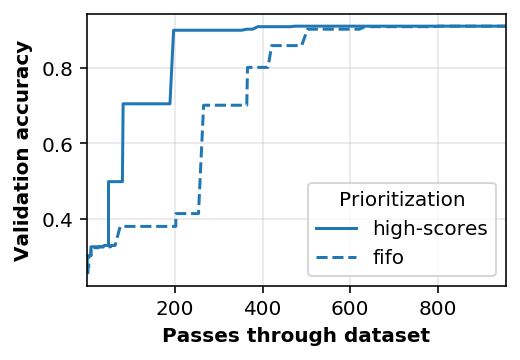

In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

w = 2.5
fig, ax = plt.subplots(figsize=(1.5 * w, w))

styles = {"fifo": "--", "high-scores": "-"}
for sampling in df.sampling.unique():
    show = df[df.sampling == sampling]
    if sampling == "none":
        sampling = "fifo"
    show.plot(x="epochs", y="best_score", color="C0", style=styles[sampling], ax=ax, label=sampling)
    print(show.best_score.iloc[-1])

# ax.set_ylim(0.7, None)
ax.legend(loc="lower right", title="Prioritization")
ax.grid(linestyle="-", alpha=0.3)
fontdict = {"weight": "bold"}
ax.set_ylabel("Validation accuracy", fontdict=fontdict)
ax.set_xlabel("Passes through dataset", fontdict=fontdict)
plt.savefig("figs/synthetic-priority.pdf", bbox_inches="tight")

In [258]:
df[df.sampling == "none"].best_score.iloc[-1]

0.9095489443378119

In [259]:
df[df.sampling == "high-scores"].best_score.iloc[-1]

0.9095489443378119

In [260]:
all_runs = pd.read_csv("all-runs.csv")

In [261]:
passive = all_runs[all_runs["alg"] == "passive"]
passive.head()

,best_score,elapsed_wall_time,cumulative_partial_fit_calls,random_state,alg,k,epochs
130000,0.248800,0.000000,0,400,passive,0,0.0
130001,0.265715,0.000002,0,400,passive,0,0.0
130002,0.265715,0.000004,0,400,passive,0,0.0
130003,0.265715,0.000005,0,400,passive,0,0.0
130004,0.265715,0.000006,0,400,passive,0,0.0


In [262]:
passive.quantile(0.21)

best_score                         0.440019
elapsed_wall_time                 29.225336
cumulative_partial_fit_calls    1020.000000
random_state                     441.790000
k                                 41.790000
epochs                           170.000000
Name: 0.21, dtype: float64

In [263]:
kwargs = {"index": "epochs", "values": "best_score"}
middle = passive.pivot_table(aggfunc="mean", **kwargs)
lower = passive.pivot_table(aggfunc=lambda x: x.quantile(0.25), **kwargs)
upper = passive.pivot_table(aggfunc=lambda x: x.quantile(0.75), **kwargs)

0.9095489443378119
0.9095489443378119


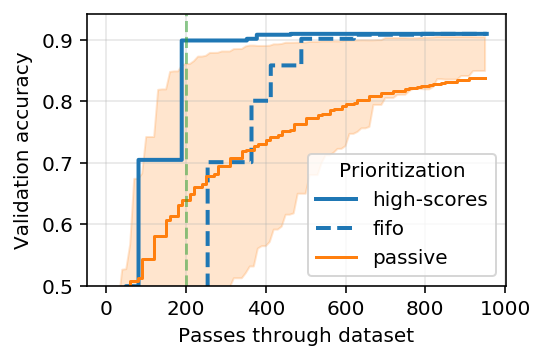

In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

w = 2.5
fig, ax = plt.subplots(figsize=(1.5 * w, w))

styles = {"fifo": "--", "high-scores": "-"}
for sampling in df.sampling.unique():
    show = df[df.sampling == sampling]
    if sampling == "none":
        sampling = "fifo"
    ax.step(
        show.epochs.values.flatten(),
        show.best_score.values.flatten(),
        "C0" + styles[sampling],
        label=sampling,
        linewidth=2,
    )
    print(show.best_score.iloc[-1])
    
ax.step(middle.index, middle.values, color="C1", label="passive", linewidth=1.5)
ax.fill_between(upper.index, lower.values.flatten(), upper.values.flatten(), color="C1", alpha=0.2)
# ax.step(middle.index, middle.values, color="C1", label="passive", linewidth=1)

# ax.set_ylim(0.7, None)
ax.legend(loc="lower right", title="Prioritization")
ax.grid(linestyle="-", alpha=0.3)
# fontdict = {"weight": "bold"}
fontdict = {}
ax.set_ylabel("Validation accuracy", fontdict=fontdict)
ax.set_xlabel("Passes through dataset", fontdict=fontdict)
ax.set_ylim(0.5, None)
ax.plot([200, 200], ax.get_ylim(), "C2--", alpha=0.5)
plt.savefig(f"figs/synthetic-priority-w-passive-{rs}-w-bars.pdf", bbox_inches="tight")

In [276]:
ax.fill_between?

Signature:
ax.fill_between(
    x,
    y1,
    y2=0,
    where=None,
    interpolate=False,
    step=None,
    *,
    data=None,
    **kwargs,
)
Docstring:
Fill the area between two horizontal curves.

The curves are defined by the points (*x*, *y1*) and (*x*, *y2*). This
creates one or multiple polygons describing the filled area.

You may exclude some horizontal sections from filling using *where*.

By default, the edges connect the given points directly. Use *step* if
the filling should be a step function, i.e. constant in between *x*.


Parameters
----------
x : array (length N)
    The x coordinates of the nodes defining the curves.

y1 : array (length N) or scalar
    The y coordinates of the nodes defining the first curve.

y2 : array (length N) or scalar, optional, default: 0
    The y coordinates of the nodes defining the second curve.

where : array of bool (length N), optional, default: None
    Define *where* to exclude some horizontal regions from being
    filled. The fil